# How can we more effectively match films across the Netflix and Rotten Tomatoes Datasets?

#### Import Libraries

In [2]:
import pandas as pd
import plotly.express as px
import slugify as slugify

Create DataFrame from Netflix CSV, filtered to just movies

Create DataFrame from Rotten Tomatoes Movies CSV

# Pre-Merge

The Netflix dataset has been filtered to just Movies, as RT does not contain TV Show data

In [3]:
netflix_movies_df = pd.read_csv('./data/netflix-titles.csv', parse_dates=['date_added'])
netflix_movies_df = netflix_movies_df[netflix_movies_df["type"] == 'Movie']
rotten_movies_df = pd.read_csv('./data/rotten_tomatoes_movies.csv')

print(f"Movies in Netflix Dataset: {len(netflix_movies_df.index)}")
print(f"Movies in Rotten Tomatoes Dataset: {len(rotten_movies_df.index)}")

Movies in Netflix Dataset: 6131
Movies in Rotten Tomatoes Dataset: 17712


### Slug of 'Title' and 'Release Year' as a Unique identifier column

In [6]:
netflix_movies_df["title_and_release_year"] = netflix_movies_df["title"] + " " + netflix_movies_df["release_year"].astype(str)
netflix_movies_df["title_and_release_year"] = netflix_movies_df["title_and_release_year"].apply(slugify.slugify)

# Extract release_year from Rotten Tomatoes original_release_date
rotten_movies_df["release_year"] = rotten_movies_df["original_release_date"].str.split('-').str[0]
rotten_movies_df["title_and_release_year"] = rotten_movies_df["movie_title"] + " " + rotten_movies_df["release_year"].astype(str)
rotten_movies_df["title_and_release_year"] = rotten_movies_df["title_and_release_year"].apply(slugify.slugify)

Merge the above datasets, keeping the entire Netflix set and dumping the Rotten tomatoes that don't match the Netflix Set

In [7]:
merged_on_title_release_year_slug = pd.merge(netflix_movies_df, rotten_movies_df, how="inner", on="title_and_release_year", indicator=True)

print(f"Movies after merging on 'Title' and 'Release Year': {len(merged_on_title_release_year_slug.index)}")

Movies after merging on 'Title' and 'Release Year': 1283


### Slug of 'Title' and 'Director' as a Unique identifier column

ISSUE: The 'directors' column on RT can contain multiple directors as a csv string

ISSUE: The 'director' column on Netflix also can contain multiple directors as a csv string

Try Merging anyway?
- hopefully it's consistent between the two datasets

In [12]:
netflix_movies_df["title_and_director"] = netflix_movies_df["title"] + " " + netflix_movies_df["director"].astype(str)
netflix_movies_df["title_and_director"] = netflix_movies_df["title_and_director"].apply(slugify.slugify)

rotten_movies_df["title_and_director"] = rotten_movies_df["movie_title"] + " " + rotten_movies_df["directors"].astype(str)
rotten_movies_df["title_and_director"] = rotten_movies_df["title_and_director"].apply(slugify.slugify)

In [10]:
merged_on_title_director_slug = pd.merge(netflix_movies_df, rotten_movies_df, how="inner", on="title_and_director", indicator=True)

print(f"Movies after merging on 'Title' and 'Director(s)': {len(merged_on_title_director_slug.index)}")

Movies after merging on 'Title' and 'Director(s)': 1547


Try merging on 'First Director'

Add column that is set to index 0 of splitting the director(s) column to each

In [14]:
netflix_movies_df["title_and_first_director"] = netflix_movies_df["title"] + " " + netflix_movies_df["director"].str.split(',').str[0].astype(str)
netflix_movies_df["title_and_first_director"] = netflix_movies_df["title_and_first_director"].apply(slugify.slugify)

rotten_movies_df["title_and_first_director"] = rotten_movies_df["movie_title"] + " " + rotten_movies_df["directors"].str.split(',').str[0].astype(str)
rotten_movies_df["title_and_first_director"] = rotten_movies_df["title_and_first_director"].apply(slugify.slugify)

In [15]:
merged_on_title_first_director_slug = pd.merge(netflix_movies_df, rotten_movies_df, how="inner", on="title_and_first_director", indicator=True)

print(f"Movies after merging on 'Title' and 'First Director': {len(merged_on_title_first_director_slug.index)}")

Movies after merging on 'Title' and 'First Director': 1600


Would it be possible to match on any variation of title plus director?

Are there typos/changes in spelling between the director names? e.g. accents, special characters, apostrophe handling

Is there another possible linking option?
- runtime/duration => would needs to clean the 'mins' string part and convert to int
- All other columns have either too much variety (e.g. 'cast' string) or are unique to that dataset => no overlap

### Current best option

Merge on Title and First Listed Director => 1600 entries

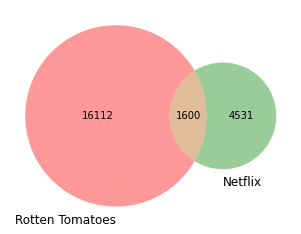

Netflix Only: 4531
Netflix and on Rotten Tomatoes: 1600
Netflix Total: 6131
Not on Netflix: 16112


In [16]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

merged_outer_title_first_director_slug = pd.merge(netflix_movies_df, rotten_movies_df, how="outer", on="title_and_first_director", indicator=True)

mapping_dict = {
  "left_only": "Netflix",
  "both": "Both",
  "right_only": "Rotten Tomatoes",
}

merged_outer_title_first_director_slug.rename(columns={"_merge":"dataset_location"}, inplace=True)
merged_outer_title_first_director_slug.replace({"dataset_location": mapping_dict}, inplace=True)

merged_on_title_first_director_slug = pd.merge(netflix_movies_df, rotten_movies_df, how="inner", on="title_and_first_director", indicator=True)

netflix_count = len(merged_outer_title_first_director_slug[merged_outer_title_first_director_slug["dataset_location"] == "Netflix"])
rotten_tomatoes_count = len(merged_outer_title_first_director_slug[merged_outer_title_first_director_slug["dataset_location"] == "Rotten Tomatoes"])
overlap_count = len(merged_outer_title_first_director_slug[merged_outer_title_first_director_slug["dataset_location"] == "Both"])

missing_from_netflix_df = merged_outer_title_first_director_slug[merged_outer_title_first_director_slug["dataset_location"] == "Rotten Tomatoes"]

# Use the venn2 function
venn2(subsets = (rotten_tomatoes_count, netflix_count, overlap_count), set_labels = ('Rotten Tomatoes', 'Netflix'))
plt.show()

print(f"Netflix Only: {netflix_count}")
print(f"Netflix and on Rotten Tomatoes: {overlap_count}")
print(f"Netflix Total: {netflix_count + overlap_count}")
print(f"Not on Netflix: {rotten_tomatoes_count}")